# ResNet for CIFAR-10 
**based on Section 4.2 in "Deep Residual Learning for Image Recognition" from Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun**
(https://arxiv.org/abs/1512.03385)

 **Google Colab Setup**

(Skip the next two cells, if you don't use colab)

In [1]:
# for using the Google Colaboratory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Check GPU RAM usage in Google Colab
# from: https://gist.github.com/okomarov/c0d9fd0718f6f9b40c701e61523dfed1
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  |     Proc size: 118.4 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total     11441MB


 **ResNet Implementation**

The ResNet architecture is implemented in `ResNet.py`.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np

In [4]:
# use GPU if available
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [5]:
# Check basic functionality of architecture
from ResNet import ResNet, ResidualBlocks, ConvBlock

def test_ResNet():
    n = 1
    x = torch.zeros((64, 3, 32, 32), dtype=dtype) # minibatch size 64
    x = x.to(device)
    model = ResNet(n)
    model.to(device)
    print(model)
    scores = model(x)
    print(scores.size())
    
test_ResNet()

ResNet(
  (initial_layer): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layerBlock1): ResidualBlocks(
    (blocks): Sequential(
      (0): ConvBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layerBlock2): ResidualBlocks(
    (blocks): Sequential(
      (0): ConvBlock(
        (max): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2):

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
# import CIFAR data and perform data augmentation

NUM_TRAIN = 45000
batch_size = 128

normalize = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

augment = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomCrop(32, padding=4)
            ])


cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True, transform=T.Compose([augment, normalize]))
loader_train = DataLoader(cifar10_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True, transform=normalize)
loader_val = DataLoader(cifar10_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, transform=normalize)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
# auxilary functions for training and evaluation


def check_accuracy_batch(scores, labels, verbose=False):
    """
    Computes the accuracy of a data batch

    Inputs: 
    - scores: (torch.tensor) A PyTorch tensor with score values for labels
    - labels: (torch.tensor) A PyTorch tensor with ground truth labels
    - verbose: (boolean) Switches printing of scores on and off

    Returns: 
    - acc: (Float) Accuracy of correct predicted labels for the batch
    """
    _, preds = scores.max(1)
    num_correct = (labels == preds).sum()
    num_samples = preds.size(0)
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc



def train_ResNet(model, optimizer, dataloader):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model: (torch.nn.Module) A PyTorch module giving the model to train.
    - optimizer: (torch.optim) An optimizer object we will use to train the model
    - dataloader: (DataLoader) A DataLoader object supplying the training data
    
    Returns: 
    - loss_history: (list) A list of training losses
    - accuracy_history: (list) A list of corresponding accuracies
    """
    # set model to training mode
    model.train()
    
    # define history lists
    loss_history = []
    accuracy_history = []
    iterations_per_epoch = max(NUM_TRAIN / batch_size, 1)

    for it, (data_batch, labels_batch) in enumerate(dataloader):

        # put data to device
        data_batch, labels_batch = data_batch.to(device=device, dtype=dtype), labels_batch.to(device=device, dtype=torch.long)
        
        # compute scores and loss
        scores = model(data_batch)
        loss = F.cross_entropy(scores, labels_batch)
        loss_history.append(loss)

        # check batch accuracy after each epoch
        if it % iterations_per_epoch == 0:   
          if verbose == True:
            print('Train accuracy:')
          accuracy = check_accuracy_batch(scores, labels_batch, verbose=verbose)
          accuracy_history.append(accuracy)

        # clear previous gradients and build gradient computational graph
        optimizer.zero_grad() 
        loss.backward()
        
        # actual backprop und updating params
        optimizer.step()
        
    return {
        'loss_history': loss_history, 
        'accuracy_history': accuracy_history
        }
    
    
def evaluate_ResNet(model, dataloader):
    """
    Evaluate a model on CIFAR-10.
    
    Inputs:
    - model: (torch.nn.Module) A PyTorch module giving the model to train.
    - dataloader: (DataLoader) A DataLoader object supplying the training data
    
    Returns: 
    - loss_history: (list) A list of validation/test losses
    - accuracy_history: (list) A list of corresponding accuracies
    """
    # set model to evaluation mode
    model.eval()
    
    # define history lists
    loss_history = []
    accuracy_history = []
    iterations_per_epoch = max(NUM_TRAIN / batch_size, 1)

    #if dataloader.dataset.train == True:
    #  print("Evaluating accuracies on validation set")
    #else:
    #  print("Evaluating accuracies on test set")
    
    with torch.no_grad():
      for it, (data_batch, labels_batch) in enumerate(dataloader):
        data_batch, labels_batch = data_batch.to(device=device, dtype=dtype), labels_batch.to(device=device, dtype=torch.long)

        
        # compute scores and loss
        scores = model(data_batch)
        loss = F.cross_entropy(scores, labels_batch)
        loss_history.append(loss)

        # check batch accuracy after each epoch
        if it % iterations_per_epoch == 0:
          if verbose == True:
            if dataloader.dataset.train == True:
                print('Validation accuracy:')
            else:
                print('Test accuracy:')
          accuracy = check_accuracy_batch(scores, labels_batch, verbose=verbose)
          accuracy_history.append(accuracy)
        
    return {
        'loss_history': loss_history, 
        'accuracy_history': accuracy_history
        }


In [8]:
# Train for 5 epochs

# initialize model and optimizer with hyperparameters
epochs = 5
n = 3
lr = 0.1
model = ResNet(n)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
overall_train_loss, overall_val_loss, overall_train_acc, overall_val_acc = [], [], [], []

# Print training accuracies
verbose = True

best_model = None
best_val_acc = -1

for epoch in range(epochs):
    print('Epoch ', epoch+1)
    train_stats = train_ResNet(model, optimizer, loader_train)
    val_stats = evaluate_ResNet(model, loader_val)
    scheduler.step()
    overall_train_loss += train_stats['loss_history']
    overall_train_acc += train_stats['accuracy_history']
    overall_val_loss += val_stats['loss_history']
    overall_val_acc += val_stats['accuracy_history']

    val_acc_avg = np.mean(val_stats['accuracy_history'][-1])
    if val_acc_avg > best_val_acc:
      best_model = model
      best_val_acc = val_acc_avg


Epoch  1
Train accuracy:
Got 16 / 128 correct (12.50)
Validation accuracy:
Got 63 / 128 correct (49.22)
Epoch  2
Train accuracy:
Got 69 / 128 correct (53.91)
Validation accuracy:
Got 81 / 128 correct (63.28)
Epoch  3
Train accuracy:
Got 84 / 128 correct (65.62)
Validation accuracy:
Got 93 / 128 correct (72.66)
Epoch  4
Train accuracy:
Got 91 / 128 correct (71.09)
Validation accuracy:
Got 88 / 128 correct (68.75)
Epoch  5
Train accuracy:
Got 94 / 128 correct (73.44)
Validation accuracy:
Got 85 / 128 correct (66.41)


In [9]:
best_val_acc

0.7265625

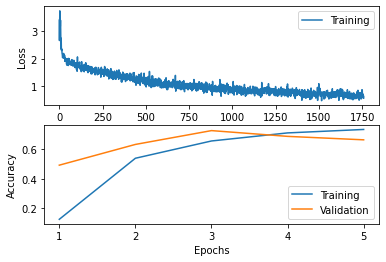

In [10]:
# plot loss and accuracy curves
def plot_loss_acc(train_loss, train_acc, val_loss, val_acc):   
    plt.subplot(2, 1, 1)
    plt.plot(train_loss)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(['Training'])

    plt.subplot(2, 1, 2)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
    
plot_loss_acc(overall_train_loss, overall_train_acc, overall_val_loss, overall_val_acc)

In [11]:
# test accuracy
test_stats = evaluate_ResNet(model, loader_test)

print('Final accuracy on test set: %f' % test_stats['accuracy_history'][-1])

Test accuracy:
Got 85 / 128 correct (66.41)
Final accuracy on test set: 0.664062


In [12]:
def count_params(model):
    """
    Number of (learned) parameters in the model.
    Inputs:
    - model: (torch.nn.Module) A PyTorch module giving the model.
    Returns:
    -      : (int) Number of parameters
    """
    return sum([np.prod(p.size()) for p in model.parameters()])

In [13]:
count_params(model)

270410